In [4]:
# import lib
import os
from PIL import Image, ImageDraw, ImageFont, ImageTransform
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from glob import glob
import sys
sys.path.append('../../database')
from db_util import *
from db import *

In [32]:
# set simulator data
fontdir = '../../../data/font/*.ttf'
fontpath = glob(fontdir)
textdata = pd.read_csv('../../../data/textdata.csv',sep=',',header=None)
textdata = list(textdata.values)

In [41]:
# set simulator parameter
imageSize = (256, 128)
fontsSize = (10,30)

In [122]:
# some generators
def fontGenerator(fontpath, fontsSize):
    while True:
        fontselection = np.random.randint(0,len(fontpath),1)[0]
        fontsize = np.random.randint(fontsSize[0],fontsSize[1],1)[0]
        yield ImageFont.truetype(fontpath[fontselection], fontsize)
fontgen = fontGenerator(fontpath, fontsSize)

def textGenerator(textdata):
    while True:
        textselection = np.random.randint(0,len(textdata),1)[0]
        yield str(textdata[textselection])       
textgen = textGenerator(textdata[0])

def locGenerator(imageSize):
    while True:
        x = np.random.randint(imageSize[0]//8,imageSize[0]//4,1)[0]
        y = np.random.randint(imageSize[1]//8,imageSize[1]//4,1)[0]
        yield [x,y]
locgen = locGenerator(imageSize)

def textcoordinates(font, text, loc):
    char_table = pd.DataFrame({'x1':[], 'y1':[], 'x2':[], 'y2':[], 'x3':[], 'y3':[],
                                     'x4':[], 'y4':[], 'char':[]})
    for i, char in enumerate(text):
        b1 = font.getsize('A')[1]
        r, b2 = font.getsize(text[:i+1])
        b = b1 if b1 < b2 else b2
        w, _ = font.getmask(char).size
        _, h = font.getmask('A').size
        r += loc[0]
        b += loc[1]
        t = b - h
        l = r - w
        right = int(np.round(r))
        bottom = int(np.round(b))
        top = int(np.round(t))
        left = int(np.round(l))
        if i == 0:
            char_data = pd.DataFrame({'x1':[left-2], 'y1':[top], 
                                     'x2':[left-2], 'y2':[top],
                                     'x3':[left-2], 'y3':[bottom],
                                     'x4':[left-2], 'y4':[bottom], 'char':' '})
            char_table = char_table.append(char_data, ignore_index=True)
        if text[i] != ' ':
            char_data = pd.DataFrame({'x1':[left], 'y1':[top], 
                                     'x2':[right], 'y2':[top],
                                     'x3':[right], 'y3':[bottom],
                                     'x4':[left], 'y4':[bottom], 'char':text[i]})
            char_table = char_table.append(char_data, ignore_index=True)
        if i == len(text)-1:
            char_data = pd.DataFrame({'x1':[right+2], 'y1':[top], 
                                     'x2':[right+2], 'y2':[top],
                                     'x3':[right+2], 'y3':[bottom],
                                     'x4':[left+2], 'y4':[bottom], 'char':' '})
            char_table = char_table.append(char_data, ignore_index=True)
            
    return char_table

In [142]:
# create image
img = Image.new('RGB', imageSize, color='White')
draw = ImageDraw.Draw(img)
# first text
font = next(fontgen)
text = next(textgen)
loc = next(locgen)
draw.text(loc, text, fill=(0,0,0), font=font)
tb = textcoordinates(font, text, loc)


# second text
loc[1] = loc[1]*2
font = next(fontgen)
text = next(textgen)
draw.text(loc, text, fill=(0,0,0), font=font)
tb = tb.append(textcoordinates(font, text, loc))

#for x1,y1,_,_,x3,y3,_,_,_ in tb.values:
#    draw.rectangle((x1,y1,x3,y3),None,'#f00')


,x1,y1,x2,y2,x3,y3,x4,y4,char
0,34.0,27.0,34.0,27.0,34.0,44.0,34.0,44.0,
1,36.0,27.0,51.0,27.0,51.0,44.0,36.0,44.0,A
2,51.0,27.0,65.0,27.0,65.0,44.0,51.0,44.0,N
3,65.0,27.0,77.0,27.0,77.0,44.0,65.0,44.0,D
4,79.0,27.0,79.0,27.0,79.0,44.0,67.0,44.0,
0,34.0,64.0,34.0,64.0,34.0,85.0,34.0,85.0,
1,36.0,64.0,66.0,64.0,66.0,85.0,36.0,85.0,W
2,65.0,64.0,83.0,64.0,83.0,85.0,65.0,85.0,E
3,83.0,64.0,103.0,64.0,103.0,85.0,83.0,85.0,T
4,105.0,64.0,105.0,64.0,105.0,85.0,85.0,85.0,


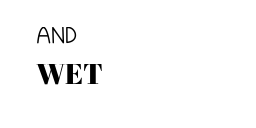

In [143]:
display(tb)
img